# Task 1

## Create table for SA2 Regions

In [1]:
# commands for library installations in case the user running this does not have them
!pip3 install geopandas
!pip3 install geoalchemy2
!pip3 install folium

from sqlalchemy import create_engine, text
import psycopg2 # For PostgreSQL database connections
import psycopg2.extras
import json # For handling JSON data
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt # For plotting data

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [2]:
sa2=gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
sa2

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,901031003,Jervis Bay,0,No change,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,67.2296,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((150.69567 -35.18295, 150.69556..."
2469,901041004,Norfolk Island,0,No change,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,38.6510,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((167.96325 -29.07212, 167.96326..."
2470,997979799,Migratory - Offshore - Shipping (OT),0,No change,99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None
2471,999999499,No usual address (OT),0,No change,99999,No usual address (OT),999,No usual address (OT),99499,No usual address (OT),9,Other Territories,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None


In [3]:
def create_wkt_element(geom, srid=4283):
    if geom is not None:
        if geom.geom_type == 'Polygon':
            geom = MultiPolygon([geom])
        return WKTElement(geom.wkt, srid)
    else:
        return None

srid = 4283

# Apply the function to each geometry
sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))

# Drop the original geometry column
sa2 = sa2.drop(columns="geometry")

In [4]:
# filtering for only Greater Sydney Regions
sa2 = sa2[sa2.GCC_NAME21 == 'Greater Sydney']

In [5]:
import logging  # For logging information and errors

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Function to execute SQL commands with transaction handling
def execute_sql(connection, query):
    trans = connection.begin()  # Start a transaction
    try:
        connection.execute(text(query))
        trans.commit()  # Commit the transaction
        logging.info("SQL executed successfully: %s", query)
    except Exception as e:
        trans.rollback()  # Rollback the transaction if there's an error
        logging.error("Error executing SQL: %s", e)

# Create a connection to the database
credentials = "Credentials.json"
db, conn = pgconnect(credentials)

# Creating the regions tables
execute_sql(conn, """
DROP TABLE IF EXISTS sa2_regions CASCADE;
CREATE TABLE sa2_regions (
    sa2_code CHAR(9) PRIMARY KEY,
    sa2_name VARCHAR(50),
    change_flag INTEGER,
    change_label VARCHAR(11),
    sa3_code CHAR(5),
    sa3_name VARCHAR(50),
    sa4_code CHAR(3),
    sa4_name VARCHAR(50),
    gcc_code CHAR(5),
    gcc_name VARCHAR(50),
    ste_code CHAR(1),
    ste_name VARCHAR(50),
    aus_code CHAR(3),
    aus_name VARCHAR(50),
    area_sq_km NUMERIC,
    loci_uri VARCHAR(1000),
    geometry GEOMETRY(MULTIPOLYGON, 4283)
);
""")

2024-05-15 21:39:32,146 - INFO - SQL executed successfully: 
DROP TABLE IF EXISTS sa2_regions CASCADE;
CREATE TABLE sa2_regions (
    sa2_code CHAR(9) PRIMARY KEY,
    sa2_name VARCHAR(50),
    change_flag INTEGER,
    change_label VARCHAR(11),
    sa3_code CHAR(5),
    sa3_name VARCHAR(50),
    sa4_code CHAR(3),
    sa4_name VARCHAR(50),
    gcc_code CHAR(5),
    gcc_name VARCHAR(50),
    ste_code CHAR(1),
    ste_name VARCHAR(50),
    aus_code CHAR(3),
    aus_name VARCHAR(50),
    area_sq_km NUMERIC,
    loci_uri VARCHAR(1000),
    geometry GEOMETRY(MULTIPOLYGON, 4283)
);



Connected successfully.


In [6]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [7]:
# Replace NaN in all numeric columns with 0, excluding geometry column
numeric_cols = sa2.select_dtypes(include=['number']).columns
sa2[numeric_cols] = sa2[numeric_cols].fillna(0)

# Selecting all columns that have data type 'object' which are generally strings, excluding geometry
string_cols = sa2.select_dtypes(include='object').columns.difference(['geom'])
sa2[string_cols] = sa2[string_cols].fillna('Unknown')

# Define a dictionary that maps old column names to new ones
column_mapping = {
    'SA2_CODE21': 'sa2_code',
    'SA2_NAME21': 'sa2_name',
    'CHG_FLAG21': 'change_flag',
    'CHG_LBL21': 'change_label',
    'SA3_CODE21': 'sa3_code',
    'SA3_NAME21': 'sa3_name',
    'SA4_CODE21': 'sa4_code',
    'SA4_NAME21': 'sa4_name',
    'GCC_CODE21': 'gcc_code',
    'GCC_NAME21': 'gcc_name',
    'STE_CODE21': 'ste_code',
    'STE_NAME21': 'ste_name',
    'AUS_CODE21': 'aus_code',
    'AUS_NAME21': 'aus_name',
    'AREASQKM21': 'area_sq_km',
    'LOCI_URI21': 'loci_uri',
    'geom': 'geometry'  # Ensure 'geom' is the correct geometry column name in the DataFrame
}

# Rename the columns in the DataFrame
sa2.rename(columns=column_mapping, inplace=True)

# Ensure the DataFrame columns are in the exact order as the SQL table
sa2 = sa2[['sa2_code', 'sa2_name', 'change_flag', 'change_label', 'sa3_code', 'sa3_name',
           'sa4_code', 'sa4_name', 'gcc_code', 'gcc_name', 'ste_code', 'ste_name',
           'aus_code', 'aus_name', 'area_sq_km', 'loci_uri', 'geometry']]

In [8]:
from sqlalchemy.dialects.postgresql import BYTEA  # since we're using PostgreSQL
from sqlalchemy import text
from geoalchemy2.shape import to_shape, from_shape



# Use the existing connection to insert data, making sure to use 'geometry' for the column name if required by the table schema
try:
    sa2.to_sql('sa2_regions', conn, if_exists='append', index=False,
               dtype={'geometry': Geometry('MULTIPOLYGON', srid=4283)})  # specifying dtype is crucial
    print("Data inserted successfully")
except Exception as e:
    print("An error occurred: ", e)
    conn.execute(text('ROLLBACK'))


Data inserted successfully


In [9]:
query(conn, text("select * from sa2_regions"))

,sa2_code,sa2_name,change_flag,change_label,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,aus_code,aus_name,area_sq_km,loci_uri,geometry
0,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000010...
2,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB100000010000000103000000010000007E...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,7.7550,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000089...
370,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,8.9538,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB100000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,3.8436,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB10000001000000010300000001000000A1...


## Create table for business

In [10]:
business = pd.read_csv('Businesses.csv')
# only dealing with businesses in the Greater Sydney region
business_GSA = business['sa2_code'].isin(pd.to_numeric(sa2['sa2_code']))
business = business[business_GSA]

In [11]:
business_table_sql = """
DROP TABLE IF EXISTS businesses;
CREATE TABLE businesses (
    industry_code CHAR(1),
    industry_name VARCHAR(255),
    sa2_code CHAR(9) REFERENCES sa2_regions (sa2_code),
    sa2_name VARCHAR(50),
    "0_to_50k_businesses" INTEGER,
    "50k_to_200k_businesses" INTEGER,
    "200k_to_2m_businesses" INTEGER,
    "2m_to_5m_businesses" INTEGER,
    "5m_to_10m_businesses" INTEGER,
    "10m_or_more_businesses" INTEGER,
    total_businesses INTEGER,
    PRIMARY KEY (industry_code, sa2_code)
);
"""

# Replace NaN in all numeric columns with 0, excluding geometry column
numeric_cols = business.select_dtypes(include=['number']).columns
business[numeric_cols] = business[numeric_cols].fillna(0)

try:
    # Execute the SQL command to create the table
    conn.execute(text(business_table_sql))
    print("Table created successfully")
except Exception as e:
    print("An error occurred:", e)

Table created successfully


In [12]:
try:
    business.to_sql('businesses', conn, if_exists='append', index=False)
    print("Data inserted successfully")
    query(conn, text("select * from businesses"))
except Exception as e:
    print("An error occurred: ", e)
    conn.execute(text('ROLLBACK'))

Data inserted successfully


In [13]:
query(conn, text("select * from businesses"))

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",102011028,Avoca Beach - Copacabana,3,0,3,0,0,0,6
1,A,"Agriculture, Forestry and Fishing",102011029,Box Head - MacMasters Beach,8,6,3,0,0,0,17
2,A,"Agriculture, Forestry and Fishing",102011030,Calga - Kulnura,69,43,94,5,3,3,215
3,A,"Agriculture, Forestry and Fishing",102011031,Erina - Green Point,12,8,4,3,0,0,27
4,A,"Agriculture, Forestry and Fishing",102011032,Gosford - Springfield,8,5,6,0,0,0,19
...,...,...,...,...,...,...,...,...,...,...,...
7082,S,Other Services,128021537,Royal National Park,0,0,0,0,0,0,0
7083,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
7084,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
7085,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22


# Create table for Stops

In [14]:
stops = pd.read_csv('Stops.txt')
stops

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN
...,...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",-33.822016,151.078797,NaN,21271,1,B
114714,2137185,2137185.0,"Cabarita Wharf, Side A",-33.840669,151.116926,NaN,21371,1,1A
114715,2137186,2137186.0,"Cabarita Wharf, Side B",-33.840769,151.116899,NaN,21371,1,1B
114716,21501,21501.0,Parramatta Wharf,-33.813904,151.010577,NaN,2150112,1,NaN


In [15]:
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)  # creating the geometry column
stops = stops.drop(columns=['stop_lat', 'stop_lon'])  # removing the old latitude/longitude fields
stops

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",NaN,200060,0,NaN,POINT (151.20666 -33.88221)
1,200054,200054.0,"Central Station, Eddy Av, Stand D",NaN,200060,0,NaN,POINT (151.20699 -33.88204)
2,200060,NaN,Central Station,1.0,NaN,0,NaN,POINT (151.20629 -33.88408)
3,201510,NaN,Redfern Station,1.0,NaN,0,NaN,POINT (151.19887 -33.89169)
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",NaN,201510,0,NaN,POINT (151.19888 -33.89333)
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",NaN,21271,1,B,POINT (151.07880 -33.82202)
114714,2137185,2137185.0,"Cabarita Wharf, Side A",NaN,21371,1,1A,POINT (151.11693 -33.84067)
114715,2137186,2137186.0,"Cabarita Wharf, Side B",NaN,21371,1,1B,POINT (151.11690 -33.84077)
114716,21501,21501.0,Parramatta Wharf,NaN,2150112,1,NaN,POINT (151.01058 -33.81390)


In [16]:
from shapely.wkt import loads

# Replace NaN in all numeric columns with 0, excluding geometry column
numeric_cols = stops.select_dtypes(include=['number']).columns
stops[numeric_cols] = stops[numeric_cols].fillna(0)

# Selecting all columns that have data type 'object' which are generally strings, excluding geometry
string_cols = stops.select_dtypes(include='object').columns.difference(['geom'])
stops[string_cols] = stops[string_cols].fillna('Unknown')


srid = 4283
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))


stops

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",0.0,200060,0,Unknown,POINT (151.20666465471 -33.8822064874687)
1,200054,200054.0,"Central Station, Eddy Av, Stand D",0.0,200060,0,Unknown,POINT (151.20699145565 -33.8820421431408)
2,200060,0.0,Central Station,1.0,Unknown,0,Unknown,POINT (151.206292455081 -33.8840842535493)
3,201510,0.0,Redfern Station,1.0,Unknown,0,Unknown,POINT (151.198866071817 -33.8916900512711)
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",0.0,201510,0,Unknown,POINT (151.198881722942 -33.8933293130144)
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",0.0,21271,1,B,POINT (151.07879697831 -33.8220164586429)
114714,2137185,2137185.0,"Cabarita Wharf, Side A",0.0,21371,1,1A,POINT (151.116926480557 -33.8406690716775)
114715,2137186,2137186.0,"Cabarita Wharf, Side B",0.0,21371,1,1B,POINT (151.116898892402 -33.8407691073139)
114716,21501,21501.0,Parramatta Wharf,0.0,2150112,1,Unknown,POINT (151.010576673346 -33.8139042429414)


In [17]:
stops_table_sql = """
DROP TABLE IF EXISTS stops;
CREATE TABLE Stops (
    stop_id VARCHAR(255) PRIMARY KEY,
    stop_code VARCHAR(255),
    stop_name VARCHAR(255),
    location_type VARCHAR(255),
    parent_station VARCHAR(255),
    wheelchair_boarding INT,
    platform_code VARCHAR(255),
    geometry GEOMETRY(POINT,4283)
)
"""

try:
    # Execute the SQL command to create the table
    conn.execute(text(stops_table_sql))
    print("Table created successfully")
except Exception as e:
    print("An error occurred:", e)

Table created successfully


In [18]:
stops.rename(columns={
    'stop_id': 'stop_id',
    'stop_code': 'stop_code',
    'stop_name': 'stop_name',
    'location_type': 'location_type',
    'parent_station': 'parent_station',
    'wheelchair_boarding': 'wheelchair_boarding',
    'platform_code': 'platform_code',
    # If 'geom' needs special handling, make sure to process it before this step
    'geom': 'geometry'
}, inplace=True)

try:
    stops.to_sql('stops', conn, if_exists='append', index=False,
               dtype={'geometry': Geometry('POINT', srid)})  # specifying dtype is crucial
    print("Data inserted successfully")
except Exception as e:
    print("An error occurred: ", e)
    conn.execute(text('ROLLBACK'))

Data inserted successfully


In [19]:
query(conn, text("select * from stops"))

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geometry
0,200039,200039.0,"Central Station, Eddy Av, Stand A",0.0,200060,0,Unknown,0101000020BB100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,200054.0,"Central Station, Eddy Av, Stand D",0.0,200060,0,Unknown,0101000020BB1000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,0.0,Central Station,1.0,Unknown,0,Unknown,0101000020BB100000817FA2F299E662408FF33DAC29F1...
3,201510,0.0,Redfern Station,1.0,Unknown,0,Unknown,0101000020BB1000009E57611C5DE6624060304CE622F2...
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",0.0,201510,0,Unknown,0101000020BB100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",0.0,21271,1,B,0101000020BB100000AF9B3D8185E262408F52D7D537E9...
114714,2137185,2137185.0,"Cabarita Wharf, Side A",0.0,21371,1,1A,0101000020BB100000EB409ADCBDE3624089CE4C0B9BEB...
114715,2137186,2137186.0,"Cabarita Wharf, Side B",0.0,21371,1,1B,0101000020BB100000C4F9BEA2BDE362403EB375529EEB...
114716,21501,21501.0,Parramatta Wharf,0.0,2150112,1,Unknown,0101000020BB100000E443E4A456E0624025C1A4032EE8...


# create table for Polls

In [20]:
polls = pd.read_csv('PollingPlaces2019.csv')

In [21]:
from shapely.wkt import loads

polls['geom'] = gpd.points_from_xy(polls.longitude, polls.latitude)  # creating the geometry column
srid = 4283

# Replace NaN in all numeric columns with 0, excluding geometry column
numeric_cols = polls.select_dtypes(include=['number']).columns
polls[numeric_cols] = polls[numeric_cols].fillna(0)

# Selecting all columns that have data type 'object' which are generally strings, excluding geometry
string_cols = polls.select_dtypes(include='object').columns.difference(['geom'])
polls[string_cols] = polls[string_cols].fillna('Unknown')


polls['geom'] = polls['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

polls

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom,geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,0.000000,0.000000,Unknown,POINT EMPTY
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,0.000000,0.000000,Unknown,POINT EMPTY
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,0.000000,0.000000,Unknown,POINT EMPTY
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,ORANGE,NSW,2800.0,0.000000,0.000000,Unknown,POINT EMPTY
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,0.000000,0.000000,Unknown,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,Unknown,Unknown,BARRACK HEIGHTS,NSW,2528.0,-34.564200,150.858000,POINT (-34.5642 150.858),POINT (150.858 -34.5642)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,Unknown,Unknown,Unknown,WARILLA,NSW,2528.0,-34.550823,150.859755,POINT (-34.5508228 150.8597546),POINT (150.8597546 -34.5508228)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,Unknown,Unknown,WELBY,NSW,2575.0,-34.440900,150.424000,POINT (-34.4409 150.424),POINT (150.424 -34.4409)
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,Unknown,Unknown,WINDANG,NSW,2528.0,-34.531600,150.866000,POINT (-34.5316 150.866),POINT (150.866 -34.5316)


In [22]:
polls = polls.drop(columns=['latitude', 'longitude', 'the_geom']) 
polls

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,POINT EMPTY
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,POINT EMPTY
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,POINT EMPTY
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,ORANGE,NSW,2800.0,POINT EMPTY
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,Unknown,Unknown,BARRACK HEIGHTS,NSW,2528.0,POINT (150.858 -34.5642)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,Unknown,Unknown,Unknown,WARILLA,NSW,2528.0,POINT (150.8597546 -34.5508228)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,Unknown,Unknown,WELBY,NSW,2575.0,POINT (150.424 -34.4409)
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,Unknown,Unknown,WINDANG,NSW,2528.0,POINT (150.866 -34.5316)


In [23]:
import logging  # For logging information and errors

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Function to execute SQL commands with transaction handling
def execute_sql(connection, query):
    trans = connection.begin()  # Start a transaction
    try:
        connection.execute(text(query))
        trans.commit()  # Commit the transaction
        logging.info("SQL executed successfully: %s", query)
    except Exception as e:
        trans.rollback()  # Rollback the transaction if there's an error
        logging.error("Error executing SQL: %s", e)

# Create a connection to the database
credentials = "Credentials.json"
db, conn = pgconnect(credentials)

execute_sql(conn, """
DROP TABLE IF EXISTS polls;
CREATE TABLE polls (
        fid VARCHAR(255),
        state VARCHAR(255),
        division_id INT,
        division_name VARCHAR(255),
        polling_place_id INT PRIMARY KEY,
        polling_place_type_id INT,
        polling_place_name VARCHAR(255),
        premises_name VARCHAR(255),
        premises_address_1 VARCHAR(255),
        premises_address_2 VARCHAR(255),
        premises_address_3 VARCHAR(255),
        premises_suburb VARCHAR(255),
        premises_state_abbreviation VARCHAR(255),
        premises_post_code INT,
        geometry GEOMETRY(POINT, 4283)
);
""")

2024-05-15 21:39:43,201 - INFO - SQL executed successfully: 
DROP TABLE IF EXISTS polls;
CREATE TABLE polls (
        fid VARCHAR(255),
        state VARCHAR(255),
        division_id INT,
        division_name VARCHAR(255),
        polling_place_id INT PRIMARY KEY,
        polling_place_type_id INT,
        polling_place_name VARCHAR(255),
        premises_name VARCHAR(255),
        premises_address_1 VARCHAR(255),
        premises_address_2 VARCHAR(255),
        premises_address_3 VARCHAR(255),
        premises_suburb VARCHAR(255),
        premises_state_abbreviation VARCHAR(255),
        premises_post_code INT,
        geometry GEOMETRY(POINT, 4283)
);



Connected successfully.


In [24]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [25]:
polls.rename(columns={
    'FID': 'fid', 
    'state': 'state',
    'division_id': 'division_id',
    'division_name': 'division_name',
    'polling_place_id': 'polling_place_id',
    'polling_place_type_id': 'polling_place_type_id',
    'polling_place_name': 'polling_place_name',
    'premises_name': 'premises_name',
    'premises_address_1': 'premises_address_1',
    'premises_address_2': 'premises_address_2',
    'premises_address_3': 'premises_address_3',
    'premises_suburb': 'premises_suburb',
    'premises_state_abbreviation': 'premises_state_abbreviation',
    'premises_post_code': 'premises_post_code',
    'geom': 'geometry'  # since the geometric column is named 'geom' in the DataFrame
}, inplace=True)
polls

,fid,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,geometry
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,POINT EMPTY
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,POINT EMPTY
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,POINT EMPTY
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,ORANGE,NSW,2800.0,POINT EMPTY
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0.0,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,Unknown,Unknown,BARRACK HEIGHTS,NSW,2528.0,POINT (150.858 -34.5642)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,Unknown,Unknown,Unknown,WARILLA,NSW,2528.0,POINT (150.8597546 -34.5508228)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,Unknown,Unknown,WELBY,NSW,2575.0,POINT (150.424 -34.4409)
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,Unknown,Unknown,WINDANG,NSW,2528.0,POINT (150.866 -34.5316)


In [26]:
from sqlalchemy.dialects.postgresql import BYTEA  # since we're using PostgreSQL
from sqlalchemy import text
from geoalchemy2.shape import to_shape, from_shape



# Using the existing connection to insert data
try:
    polls.to_sql('polls', conn, if_exists='append', index=False,
               dtype={'geometry': Geometry('POINT', 4283)})  # specifying dtype is crucial
    print("Data inserted successfully")
except Exception as e:
    print("An error occurred: ", e)
    conn.execute(text('ROLLBACK'))

Data inserted successfully


In [27]:
query(conn, text("select * from polls"))

,fid,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,geometry
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0,0101000020BB100000000000000000F87F000000000000...
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0,0101000020BB100000000000000000F87F000000000000...
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0,0101000020BB100000000000000000F87F000000000000...
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,ORANGE,NSW,2800,0101000020BB100000000000000000F87F000000000000...
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0,0101000020BB100000000000000000F87F000000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,Unknown,Unknown,BARRACK HEIGHTS,NSW,2528,0101000020BB100000FA7E6ABC74DB62409C33A2B43748...
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,Unknown,Unknown,Unknown,WARILLA,NSW,2528,0101000020BB100000BD32141C83DB624011F28B5C8146...
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,Unknown,Unknown,WELBY,NSW,2575,0101000020BB10000021B0726891CD6240386744696F38...
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,Unknown,Unknown,WINDANG,NSW,2528,0101000020BB100000C1CAA145B6DB6240DC4603780B44...


# create table for schools

In [28]:
school_primary=gpd.read_file("Catchments/catchments_primary.shp")
school_primary

# Replacing all 'Y'  with 1 and 'N' with 0
year_column_list = ['KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12']
for year in year_column_list:
    school_primary[year] = school_primary[year].map({'Y': 1, 'N': 0})
    
# converting all of these columns to numeric

for year in year_column_list:
    school_primary[year] = pd.to_numeric(school_primary[year])

In [29]:
school_secondary=gpd.read_file("Catchments/catchments_secondary.shp")
school_secondary


# Replacing all 'Y'  with 1 and 'N' with 0
year_column_list = ['KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12']
for year in year_column_list:
    school_secondary[year] = school_secondary[year].map({'Y': 1, 'N': 0})
    
# converting all of these columns to numeric

for year in year_column_list:
    school_secondary[year] = pd.to_numeric(school_secondary[year])

In [30]:
schools = pd.concat([school_primary, school_secondary], ignore_index=True)
#dropping duplicates
schools.drop_duplicates(inplace=True)

In [31]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

srid = 4283

schoolsCopy = schools.copy()  # creating a copy of the original for later
schools['geom'] = schools['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
schools = schools.drop(columns="geometry")  # deleting the old copy
schools.rename(columns = {'geom':'geometry'}, inplace = True)
schools

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,1,1,1,1,1,1,1,0,0,0,0,0,0,None,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,Lindfield EPS,20211219,1,1,1,1,1,1,1,0,0,0,0,0,0,None,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,Carlingford WPS,20220223,1,1,1,1,1,1,1,0,0,0,0,0,0,None,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,Caddies Ck PS,20181210,1,1,1,1,1,1,1,0,0,0,0,0,0,None,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,Killara PS,20211219,1,1,1,1,1,1,1,0,0,0,0,0,0,None,MULTIPOLYGON (((151.1537883781186 -33.75586174...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093,8213,HIGH_BOYS,Birrong BHS,20211221,0,0,0,0,0,0,0,1,1,1,1,1,1,None,MULTIPOLYGON (((151.05363508494244 -33.8507612...
2094,8108,HIGH_COED,Cessnock HS,20230405,0,0,0,0,0,0,0,1,1,1,1,1,1,None,MULTIPOLYGON (((151.4285214252146 -32.74415247...
2095,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,0,0,0,0,0,0,0,1,1,1,1,1,1,None,MULTIPOLYGON (((143.37723402388323 -34.8017260...
2096,1115,CENTRAL_HIGH,Balranald CS,20200512,0,0,0,0,0,0,0,1,1,1,1,1,1,None,MULTIPOLYGON (((143.65540852703225 -33.5570248...


In [32]:
db, conn = pgconnect(credentials)

schools_table_sql = """
DROP TABLE IF EXISTS schools;
CREATE TABLE schools (
    USE_ID CHAR(4),
    CATCH_TYPE VARCHAR(255),
    USE_DESC VARCHAR(255),
    ADD_DATE VARCHAR(255),
    KINDERGART INT,
    YEAR1 INT,
    YEAR2 INT,
    YEAR3 INT,
    YEAR4 INT,
    YEAR5 INT,
    YEAR6 INT,
    YEAR7 INT,
    YEAR8 INT,
    YEAR9 INT,
    YEAR10 INT,
    YEAR11 INT,
    YEAR12 INT,
    PRIORITY VARCHAR(255),
    geometry GEOMETRY(MULTIPOLYGON, 4283),
    PRIMARY KEY (USE_ID, CATCH_TYPE)
);
"""

try:
    # Execute the SQL command to create the table
    conn.execute(text(schools_table_sql))
    print("Table created successfully")
except Exception as e:
    print("An error occurred:", e)

Connected successfully.
Table created successfully


In [33]:
import numpy as np

# Replace 'None' strings and None objects with np.nan
schools['PRIORITY'] = schools['PRIORITY'].replace(['None', None], np.nan)
schools['PRIORITY'].fillna('Unknown', inplace=True)

# Display unique values in 'PRIORITY' to confirm changes
print(schools['PRIORITY'].unique())

['Unknown' 'N' 'Y']


In [34]:
# Replace NaN in all numeric columns with 0, excluding geometry column
numeric_cols = schools.select_dtypes(include=['number']).columns
schools[numeric_cols] = schools[numeric_cols].fillna(0)

# Selecting all columns that have data type 'object' which are generally strings, excluding geometry
string_cols = schools.select_dtypes(include='object').columns.difference(['geom'])
schools[string_cols] = schools[string_cols].fillna('Unknown')

In [35]:
schools

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,Lindfield EPS,20211219,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,Carlingford WPS,20220223,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,Caddies Ck PS,20181210,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,Killara PS,20211219,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,MULTIPOLYGON (((151.1537883781186 -33.75586174...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093,8213,HIGH_BOYS,Birrong BHS,20211221,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,MULTIPOLYGON (((151.05363508494244 -33.8507612...
2094,8108,HIGH_COED,Cessnock HS,20230405,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,MULTIPOLYGON (((151.4285214252146 -32.74415247...
2095,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,MULTIPOLYGON (((143.37723402388323 -34.8017260...
2096,1115,CENTRAL_HIGH,Balranald CS,20200512,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,MULTIPOLYGON (((143.65540852703225 -33.5570248...


In [36]:
# Renaming DataFrame columns to match the SQL table column names exactly
schools.rename(columns={
    'USE_ID': 'use_id',
    'CATCH_TYPE': 'catch_type',
    'USE_DESC': 'use_desc',
    'ADD_DATE': 'add_date',
    'KINDERGART': 'kindergart',
    'YEAR1': 'year1',
    'YEAR2': 'year2',
    'YEAR3': 'year3',
    'YEAR4': 'year4',
    'YEAR5': 'year5',
    'YEAR6': 'year6',
    'YEAR7': 'year7',
    'YEAR8': 'year8',
    'YEAR9': 'year9',
    'YEAR10': 'year10',
    'YEAR11': 'year11',
    'YEAR12': 'year12',
    'PRIORITY': 'priority',
    'geometry': 'geometry'  # Make sure the geometry column name matches too
}, inplace=True)

# Attempt to insert data again
try:
    schools.to_sql('schools', conn, if_exists='append', index=False, dtype={'geometry': Geometry('MULTIPOLYGON', srid=4283)})
    print("Data inserted successfully")
except Exception as e:
    print("An error occurred: ", e)
    conn.execute(text('ROLLBACK'))

Data inserted successfully


In [37]:
query(conn, text("select * from schools"))

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geometry
0,2838,PRIMARY,Parklea PS,20181210,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,0106000020BB1000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,20211219,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,0106000020BB10000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,20220223,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,0106000020BB1000000100000001030000000100000065...
3,3908,PRIMARY,Lane Cove WPS,20211219,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,0106000020BB1000000100000001030000000100000034...
4,4615,PRIMARY,Caddies Ck PS,20181210,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,0106000020BB1000000100000001030000000100000056...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093,8213,HIGH_BOYS,Birrong BHS,20211221,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,0106000020BB1000000100000001030000000100000040...
2094,8108,HIGH_COED,Cessnock HS,20230405,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,0106000020BB10000001000000010300000001000000AD...
2095,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,0106000020BB100000010000000103000000010000003E...
2096,1115,CENTRAL_HIGH,Balranald CS,20200512,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,0106000020BB100000010000000103000000010000005B...


# Create table for Population

In [38]:
population=pd.read_csv('Population.csv')
population_GSA = population['sa2_code'].isin(pd.to_numeric(sa2['sa2_code']))
# Only considering population in the Greater Sydney Area
population = population[population_GSA]
population

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


In [39]:
# Replace NaN in all numeric columns with 0, excluding geometry column
numeric_cols = population.select_dtypes(include=['number']).columns
population[numeric_cols] = population[numeric_cols].fillna(0)

# Selecting all columns that have data type 'object' which are generally strings
string_cols = population.select_dtypes(include='object').columns
population[string_cols] = population[string_cols].fillna('Unknown')

In [40]:
db, conn = pgconnect(credentials)

population_table_sql = """
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code CHAR(9) PRIMARY KEY REFERENCES sa2_regions (sa2_code),
    sa2_name VARCHAR(50),
    people_0_4 INT,
    people_5_9 INT,
    people_10_14 INT,
    people_15_19 INT,
    people_20_24 INT,
    people_25_29 INT,
    people_30_34 INT,
    people_35_39 INT,
    people_40_44 INT,
    people_45_49 INT,
    people_50_54 INT,
    people_55_59 INT,
    people_60_64 INT,
    people_65_69 INT,
    people_70_74 INT,
    people_75_79 INT,
    people_80_84 INT,
    people_85_over INT,
    total_people INT
);
"""

try:
    # Execute the SQL command to create the table
    conn.execute(text(population_table_sql))
    print("Table created successfully")
except Exception as e:
    print("An error occurred:", e)

Connected successfully.
Table created successfully


In [41]:
# Renaming DataFrame columns to match the SQL table column names exactly
population.rename(columns={
    'sa2_code': 'sa2_code',
    'sa2_name': 'sa2_name',
    '0-4_people': 'people_0_4',
    '5-9_people': 'people_5_9',
    '10-14_people': 'people_10_14',
    '15-19_people': 'people_15_19',
    '20-24_people': 'people_20_24',
    '25-29_people': 'people_25_29',
    '30-34_people': 'people_30_34',
    '35-39_people': 'people_35_39',
    '40-44_people': 'people_40_44',
    '45-49_people': 'people_45_49',
    '50-54_people': 'people_50_54',
    '55-59_people': 'people_55_59',
    '60-64_people': 'people_60_64',
    '65-69_people': 'people_65_69',
    '70-74_people': 'people_70_74',
    '75-79_people': 'people_75_79',
    '80-84_people': 'people_80_84',
    '85-and-over_people': 'people_85_over',
    'total_people': 'total_people'
}, inplace=True)

# Attempt to insert data again
try:
    population.to_sql('population', conn, if_exists='append', index=False)
    print("Data inserted successfully")
except Exception as e:
    print("An error occurred: ", e)
    conn.execute(text('ROLLBACK'))

Data inserted successfully


In [42]:
query(conn, text("select * from population"))

,sa2_code,sa2_name,people_0_4,people_5_9,people_10_14,people_15_19,people_20_24,people_25_29,people_30_34,people_35_39,...,people_45_49,people_50_54,people_55_59,people_60_64,people_65_69,people_70_74,people_75_79,people_80_84,people_85_over,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


# Create table for Income

In [43]:
income=pd.read_csv('Income.csv')

# only considering those regions in Greater Sydney
income_GSA = income['sa2_code21'].isin(pd.to_numeric(sa2['sa2_code']))
income = income[income_GSA]

income

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
28,102011028,Avoca Beach - Copacabana,4749,47,55065,77615
29,102011029,Box Head - MacMasters Beach,6636,49,51927,71509
30,102011030,Calga - Kulnura,2965,49,49168,63802
31,102011031,Erina - Green Point,8010,48,51905,71992
32,102011032,Gosford - Springfield,12051,41,54372,65283
...,...,...,...,...,...,...
637,128021537,Royal National Park,14,37,36980,47584
638,128021538,Sutherland - Kirrawee,13895,41,64940,74867
639,128021607,Engadine,10239,43,63695,72995
640,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


In [44]:
# Replace NaN in all numeric columns with 0, excluding geometry column
numeric_cols = income.select_dtypes(include=['number']).columns
income[numeric_cols] = income[numeric_cols].fillna(0)

# Replacing all 'np' in numeric columns with 0, i.e. all columns excluding sa2_name
numeric_cols = income.select_dtypes(include='object').columns.difference(['sa2_name'])
income[numeric_cols] = income[numeric_cols].replace('np', '0')

# Selecting all columns that have data type 'object' which are generally strings and filling NA with 'Unknown'
string_cols = income.select_dtypes(include='object').columns
income[string_cols] = income[string_cols].fillna('Unknown')

In [45]:
db, conn = pgconnect(credentials)

income_table_sql = """
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code CHAR(9) PRIMARY KEY REFERENCES sa2_regions (sa2_code),
    sa2_name VARCHAR(50),
    earners INT,
    median_age INT,
    median_income INT,
    mean_income INT
);
"""

try:
    # Execute the SQL command to create the table
    conn.execute(text(income_table_sql))
    print("Table created successfully")
except Exception as e:
    print("An error occurred:", e)

Connected successfully.
Table created successfully


In [46]:
# Renaming DataFrame columns to match the SQL table column names exactly
income.rename(columns={
    'sa2_code21': 'sa2_code',
    'sa2_name': 'sa2_name',
    'earners': 'earners',
    'median_age': 'median_age',
    'median_income': 'median_income',
    'mean_income': 'mean_income'
}, inplace=True)


try:
    income.to_sql('income', conn, if_exists='append', index=False)
    print("Data inserted successfully")
except Exception as e:
    print("An error occurred:", e)
    conn.execute('ROLLBACK')


Data inserted successfully


In [47]:
query(conn, text("select * from income"))

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,102011028,Avoca Beach - Copacabana,4749,47,55065,77615
1,102011029,Box Head - MacMasters Beach,6636,49,51927,71509
2,102011030,Calga - Kulnura,2965,49,49168,63802
3,102011031,Erina - Green Point,8010,48,51905,71992
4,102011032,Gosford - Springfield,12051,41,54372,65283
...,...,...,...,...,...,...
368,128021537,Royal National Park,14,37,36980,47584
369,128021538,Sutherland - Kirrawee,13895,41,64940,74867
370,128021607,Engadine,10239,43,63695,72995
371,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


Task 2

In [48]:
df_population=query(conn, text("select * from population"))
df_population

,sa2_code,sa2_name,people_0_4,people_5_9,people_10_14,people_15_19,people_20_24,people_25_29,people_30_34,people_35_39,...,people_45_49,people_50_54,people_55_59,people_60_64,people_65_69,people_70_74,people_75_79,people_80_84,people_85_over,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


In [49]:
df_sa2=query(conn, text("select * from sa2_regions"))
df_sa2

,sa2_code,sa2_name,change_flag,change_label,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,aus_code,aus_name,area_sq_km,loci_uri,geometry
0,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000010...
2,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB100000010000000103000000010000007E...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,7.7550,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000089...
370,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,8.9538,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB100000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,3.8436,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB10000001000000010300000001000000A1...


In [50]:
df_business=query(conn, text("select * from businesses"))
df_business

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",102011028,Avoca Beach - Copacabana,3,0,3,0,0,0,6
1,A,"Agriculture, Forestry and Fishing",102011029,Box Head - MacMasters Beach,8,6,3,0,0,0,17
2,A,"Agriculture, Forestry and Fishing",102011030,Calga - Kulnura,69,43,94,5,3,3,215
3,A,"Agriculture, Forestry and Fishing",102011031,Erina - Green Point,12,8,4,3,0,0,27
4,A,"Agriculture, Forestry and Fishing",102011032,Gosford - Springfield,8,5,6,0,0,0,19
...,...,...,...,...,...,...,...,...,...,...,...
7082,S,Other Services,128021537,Royal National Park,0,0,0,0,0,0,0
7083,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
7084,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
7085,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22


z score for business

In [51]:
from sqlalchemy import create_engine
import pandas as pd

# Define the SQL query to perform the calculation
sql = """
SELECT sa2.sa2_code, sa2.sa2_name, total_businesses,
       (total_businesses - AVG(total_businesses) OVER()) / STDDEV_POP(total_businesses) OVER() AS z_business
FROM sa2_regions AS sa2
JOIN (
    SELECT sa2_code, SUM(total_businesses) AS total_businesses
    FROM businesses
    GROUP BY sa2_code
) AS business ON sa2.sa2_code = business.sa2_code
JOIN population AS pop ON sa2.sa2_code = pop.sa2_code AND pop.total_people >= 100
"""

# Execute the query and load to DataFrame
df_business = pd.read_sql(sql, conn)
print(df_business)



      sa2_code                     sa2_name  total_businesses  z_business
0    102011028     Avoca Beach - Copacabana               798   -0.410646
1    102011029  Box Head - MacMasters Beach               993   -0.318543
2    102011030              Calga - Kulnura              1218   -0.212269
3    102011031          Erina - Green Point              1844    0.083406
4    102011032        Gosford - Springfield              2435    0.362550
..         ...                          ...               ...         ...
355  128021536  Oyster Bay - Como - Jannali              1549   -0.055930
356  128021538        Sutherland - Kirrawee              2205    0.253915
357  128021607                     Engadine              1095   -0.270365
358  128021608         Loftus - Yarrawarrah               437   -0.581155
359  128021609             Woronora Heights               229   -0.679399

[360 rows x 4 columns]


z scores for stops

In [52]:
query(conn, text("select * from stops"))

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geometry
0,200039,200039.0,"Central Station, Eddy Av, Stand A",0.0,200060,0,Unknown,0101000020BB100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,200054.0,"Central Station, Eddy Av, Stand D",0.0,200060,0,Unknown,0101000020BB1000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,0.0,Central Station,1.0,Unknown,0,Unknown,0101000020BB100000817FA2F299E662408FF33DAC29F1...
3,201510,0.0,Redfern Station,1.0,Unknown,0,Unknown,0101000020BB1000009E57611C5DE6624060304CE622F2...
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",0.0,201510,0,Unknown,0101000020BB100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",0.0,21271,1,B,0101000020BB100000AF9B3D8185E262408F52D7D537E9...
114714,2137185,2137185.0,"Cabarita Wharf, Side A",0.0,21371,1,1A,0101000020BB100000EB409ADCBDE3624089CE4C0B9BEB...
114715,2137186,2137186.0,"Cabarita Wharf, Side B",0.0,21371,1,1B,0101000020BB100000C4F9BEA2BDE362403EB375529EEB...
114716,21501,21501.0,Parramatta Wharf,0.0,2150112,1,Unknown,0101000020BB100000E443E4A456E0624025C1A4032EE8...


In [53]:
from sqlalchemy import create_engine
import pandas as pd

# Query to perform spatial join and count stops with population check
sql = """
SELECT sa2.sa2_code, sa2.sa2_name, COUNT(stops.stop_id) AS stop_count
FROM sa2_regions AS sa2
JOIN population AS pop ON sa2.sa2_code = pop.sa2_code AND pop.total_people >= 100
LEFT JOIN stops ON ST_Contains(sa2.geometry, stops.geometry)
GROUP BY sa2.sa2_code, sa2.sa2_name;
"""

# Execute the query
stops_data = pd.read_sql(sql, conn)


In [54]:
# Calculate z-scores for the number of stops
stops_data['z_stops'] = (stops_data['stop_count'] - stops_data['stop_count'].mean()) / stops_data['stop_count'].std()

# Display the DataFrame with z-scores
print(stops_data)

      sa2_code                     sa2_name  stop_count   z_stops
0    102011028     Avoca Beach - Copacabana         127 -0.311193
1    102011029  Box Head - MacMasters Beach         215  0.724482
2    102011030              Calga - Kulnura         172  0.218414
3    102011031          Erina - Green Point         285  1.548314
4    102011032        Gosford - Springfield         355  2.372146
..         ...                          ...         ...       ...
355  128021536  Oyster Bay - Como - Jannali         254  1.183474
356  128021538        Sutherland - Kirrawee         195  0.489101
357  128021607                     Engadine         221  0.795096
358  128021608         Loftus - Yarrawarrah         144 -0.111119
359  128021609             Woronora Heights          42 -1.311560

[360 rows x 4 columns]


z-scores for polls

In [55]:
query(conn, text("select * from polls"))

,fid,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,geometry
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0,0101000020BB100000000000000000F87F000000000000...
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0,0101000020BB100000000000000000F87F000000000000...
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0,0101000020BB100000000000000000F87F000000000000...
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,Unknown,Unknown,Unknown,ORANGE,NSW,2800,0101000020BB100000000000000000F87F000000000000...
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,Unknown,Unknown,Unknown,Unknown,NSW,0,0101000020BB100000000000000000F87F000000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,Unknown,Unknown,BARRACK HEIGHTS,NSW,2528,0101000020BB100000FA7E6ABC74DB62409C33A2B43748...
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,Unknown,Unknown,Unknown,WARILLA,NSW,2528,0101000020BB100000BD32141C83DB624011F28B5C8146...
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,Unknown,Unknown,WELBY,NSW,2575,0101000020BB10000021B0726891CD6240386744696F38...
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,Unknown,Unknown,WINDANG,NSW,2528,0101000020BB100000C1CAA145B6DB6240DC4603780B44...


In [56]:
from sqlalchemy import create_engine
import pandas as pd
from scipy.stats import zscore

# SQL query to fetch data including population check
sql = """
SELECT sa2.sa2_code, sa2.sa2_name, COUNT(polls.polling_place_id) AS polling_place_count
FROM sa2_regions AS sa2
LEFT JOIN polls 
ON ST_Contains(sa2.geometry, polls.geometry)
JOIN population AS pop 
ON sa2.sa2_code = pop.sa2_code AND pop.total_people >= 100
GROUP BY sa2.sa2_code, sa2.sa2_name;
"""

# Execute the query and load to DataFrame
polling_data = pd.read_sql(sql, conn)

# Replace missing values with 0 (if any)
polling_data['polling_place_count'] = polling_data['polling_place_count'].fillna(0)

# Calculate z-scores for the number of polling places
# To handle division by zero, add a small constant or adjust as needed
std_dev = polling_data['polling_place_count'].std()
if std_dev == 0:
    polling_data['z_polls'] = 0
else:
    polling_data['z_polls'] = zscore(polling_data['polling_place_count'])

# Display the DataFrame with z-scores
print(polling_data)



      sa2_code                     sa2_name  polling_place_count   z_polls
0    102011028     Avoca Beach - Copacabana                    2 -0.536924
1    102011029  Box Head - MacMasters Beach                    2 -0.536924
2    102011030              Calga - Kulnura                    7  0.675702
3    102011031          Erina - Green Point                    6  0.433177
4    102011032        Gosford - Springfield                    7  0.675702
..         ...                          ...                  ...       ...
355  128021536  Oyster Bay - Como - Jannali                    7  0.675702
356  128021538        Sutherland - Kirrawee                    6  0.433177
357  128021607                     Engadine                    7  0.675702
358  128021608         Loftus - Yarrawarrah                    2 -0.536924
359  128021609             Woronora Heights                    1 -0.779449

[360 rows x 4 columns]


In [57]:
query(conn, text("select * from schools"))

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geometry
0,2838,PRIMARY,Parklea PS,20181210,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,0106000020BB1000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,20211219,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,0106000020BB10000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,20220223,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,0106000020BB1000000100000001030000000100000065...
3,3908,PRIMARY,Lane Cove WPS,20211219,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,0106000020BB1000000100000001030000000100000034...
4,4615,PRIMARY,Caddies Ck PS,20181210,1,1,1,1,1,1,1,0,0,0,0,0,0,Unknown,0106000020BB1000000100000001030000000100000056...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093,8213,HIGH_BOYS,Birrong BHS,20211221,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,0106000020BB1000000100000001030000000100000040...
2094,8108,HIGH_COED,Cessnock HS,20230405,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,0106000020BB10000001000000010300000001000000AD...
2095,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,0106000020BB100000010000000103000000010000003E...
2096,1115,CENTRAL_HIGH,Balranald CS,20200512,0,0,0,0,0,0,0,1,1,1,1,1,1,Unknown,0106000020BB100000010000000103000000010000005B...


In [58]:
from sqlalchemy import create_engine
import pandas as pd
from scipy.stats import zscore


# SQL query to fetch the number of schools per SA2
query_schools = """
SELECT sa2.sa2_code, sa2.sa2_name, COUNT(schools.use_id) AS school_count
FROM sa2_regions AS sa2
LEFT JOIN schools ON ST_Contains(sa2.geometry, schools.geometry)
GROUP BY sa2.sa2_code, sa2.sa2_name;
"""

# Query to fetch the population of young people per SA2
query_population = """
SELECT sa2_code, 
       total_people,
       (people_0_4 + people_5_9 + people_10_14 + people_15_19) AS young_population
FROM population
WHERE total_people >= 100;
"""

# Execute queries
df_schools = pd.read_sql(query_schools, conn)
df_population = pd.read_sql(query_population, conn)

# Merge datasets
schools_data = df_schools.merge(df_population, on='sa2_code')

# Calculate schools per 1000 young people
schools_data['schools_per_1000'] = (schools_data['school_count'] / schools_data['young_population']) * 1000

# Compute z-scores for the number of schools per 1000 young people
schools_data['z_schools'] = zscore(schools_data['schools_per_1000'])

# Handle regions with NaN values (e.g., no young population or no schools)
schools_data['z_schools'].fillna(0, inplace=True)

schools_data=schools_data[['sa2_code', 'sa2_name', 'schools_per_1000', 'z_schools']]

# Display the data
print(schools_data)


      sa2_code                     sa2_name  schools_per_1000  z_schools
0    102011028     Avoca Beach - Copacabana          0.000000  -0.164763
1    102011029  Box Head - MacMasters Beach          0.000000  -0.164763
2    102011030              Calga - Kulnura          1.040583  14.057905
3    102011031          Erina - Green Point          0.000000  -0.164763
4    102011032        Gosford - Springfield          0.000000  -0.164763
..         ...                          ...               ...        ...
355  128021536  Oyster Bay - Como - Jannali          0.000000  -0.164763
356  128021538        Sutherland - Kirrawee          0.196928   2.526845
357  128021607                     Engadine          0.000000  -0.164763
358  128021608         Loftus - Yarrawarrah          0.000000  -0.164763
359  128021609             Woronora Heights          0.000000  -0.164763

[360 rows x 4 columns]


In [59]:
df_income=query(conn, text("select * from income"))


In [60]:
df_business

,sa2_code,sa2_name,total_businesses,z_business
0,102011028,Avoca Beach - Copacabana,798,-0.410646
1,102011029,Box Head - MacMasters Beach,993,-0.318543
2,102011030,Calga - Kulnura,1218,-0.212269
3,102011031,Erina - Green Point,1844,0.083406
4,102011032,Gosford - Springfield,2435,0.362550
...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,1549,-0.055930
356,128021538,Sutherland - Kirrawee,2205,0.253915
357,128021607,Engadine,1095,-0.270365
358,128021608,Loftus - Yarrawarrah,437,-0.581155


In [61]:
stops_data

,sa2_code,sa2_name,stop_count,z_stops
0,102011028,Avoca Beach - Copacabana,127,-0.311193
1,102011029,Box Head - MacMasters Beach,215,0.724482
2,102011030,Calga - Kulnura,172,0.218414
3,102011031,Erina - Green Point,285,1.548314
4,102011032,Gosford - Springfield,355,2.372146
...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,254,1.183474
356,128021538,Sutherland - Kirrawee,195,0.489101
357,128021607,Engadine,221,0.795096
358,128021608,Loftus - Yarrawarrah,144,-0.111119


In [62]:
polling_data

,sa2_code,sa2_name,polling_place_count,z_polls
0,102011028,Avoca Beach - Copacabana,2,-0.536924
1,102011029,Box Head - MacMasters Beach,2,-0.536924
2,102011030,Calga - Kulnura,7,0.675702
3,102011031,Erina - Green Point,6,0.433177
4,102011032,Gosford - Springfield,7,0.675702
...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,7,0.675702
356,128021538,Sutherland - Kirrawee,6,0.433177
357,128021607,Engadine,7,0.675702
358,128021608,Loftus - Yarrawarrah,2,-0.536924


In [63]:
schools_data

,sa2_code,sa2_name,schools_per_1000,z_schools
0,102011028,Avoca Beach - Copacabana,0.000000,-0.164763
1,102011029,Box Head - MacMasters Beach,0.000000,-0.164763
2,102011030,Calga - Kulnura,1.040583,14.057905
3,102011031,Erina - Green Point,0.000000,-0.164763
4,102011032,Gosford - Springfield,0.000000,-0.164763
...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,0.000000,-0.164763
356,128021538,Sutherland - Kirrawee,0.196928,2.526845
357,128021607,Engadine,0.000000,-0.164763
358,128021608,Loftus - Yarrawarrah,0.000000,-0.164763


In [64]:
import pandas as pd
import numpy as np

# Function to calculate the sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Merging all dataframes on 'sa2_code'
data_frames = [df_business, stops_data, polling_data, schools_data]
df_merged = data_frames[0]
for df in data_frames[1:]:
    df_merged = df_merged.merge(df, on=['sa2_code', 'sa2_name'], how='left')

# Calculate the final score
df_merged['final_score'] = sigmoid(df_merged['z_business'] + df_merged['z_stops'] + df_merged['z_polls'] + df_merged['z_schools'])

# Sorting the dataframe by final score in descending order
df_merged_sorted_1 = df_merged.sort_values(by='final_score', ascending=False)

# Display the dataframe with the final scores
print(df_merged_sorted_1[['sa2_code', 'sa2_name', 'final_score']])


      sa2_code                            sa2_name  final_score
95   117031644      Sydney (North) - Millers Point     1.000000
2    102011030                     Calga - Kulnura     1.000000
39   115021297  Dural - Kenthurst - Wisemans Ferry     0.999776
76   117031645          Sydney (South) - Haymarket     0.999505
284  125021477               Ermington - Rydalmere     0.998961
..         ...                                 ...          ...
359  128021609                    Woronora Heights     0.050442
59   116021562                      Acacia Gardens     0.049684
35   115011557                  Castle Hill - West     0.046012
167  119041671                         Wolli Creek     0.037970
72   117011320                         Banksmeadow     0.035215

[360 rows x 3 columns]


Task 3

In [65]:
df_merged_sorted_1

,sa2_code,sa2_name,total_businesses,z_business,stop_count,z_stops,polling_place_count,z_polls,schools_per_1000,z_schools,final_score
95,117031644,Sydney (North) - Millers Point,37597,16.970444,179,0.300797,64,14.499633,0.000000,-0.164763,1.000000
2,102011030,Calga - Kulnura,1218,-0.212269,172,0.218414,7,0.675702,1.040583,14.057905,1.000000
39,115021297,Dural - Kenthurst - Wisemans Ferry,3804,1.009163,697,6.397155,9,1.160752,0.000000,-0.164763,0.999776
76,117031645,Sydney (South) - Haymarket,8333,3.148323,77,-0.899644,27,5.526204,0.000000,-0.164763,0.999505
284,125021477,Ermington - Rydalmere,2673,0.474964,294,1.654235,6,0.433177,0.327118,4.306282,0.998961
...,...,...,...,...,...,...,...,...,...,...,...
359,128021609,Woronora Heights,229,-0.679399,42,-1.311560,1,-0.779449,0.000000,-0.164763,0.050442
59,116021562,Acacia Gardens,270,-0.660034,39,-1.346868,1,-0.779449,0.000000,-0.164763,0.049684
35,115011557,Castle Hill - West,538,-0.533450,42,-1.311560,0,-1.021974,0.000000,-0.164763,0.046012
167,119041671,Wolli Creek,861,-0.380889,12,-1.664631,0,-1.021974,0.000000,-0.164763,0.037970


In [66]:
import pandas as pd


# Top 5 and Bottom 5 regions by final score
top_bottom = pd.concat([
    df_merged_sorted_1.nlargest(5, 'final_score'),
    df_merged_sorted_1.nsmallest(5, 'final_score')
])

# Correlation of final score with other metrics
correlations = df_merged_sorted_1[['final_score', 'total_businesses', 'stop_count','polling_place_count', 'schools_per_1000']].corr()

corr_df = pd.DataFrame(correlations)
corr_df 

,final_score,total_businesses,stop_count,polling_place_count,schools_per_1000
final_score,1.000000,0.327828,0.805852,0.525928,0.297794
total_businesses,0.327828,1.000000,0.113582,0.850353,-0.013585
stop_count,0.805852,0.113582,1.000000,0.262872,0.107545
polling_place_count,0.525928,0.850353,0.262872,1.000000,0.051840
schools_per_1000,0.297794,-0.013585,0.107545,0.051840,1.000000


In [67]:
# Creating a styled table for output in a notebook or converting to HTML
styled_df = df_merged_sorted_1.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#f4f4f9'), ('color', 'black'), ('font-size', '14px')]}]
).background_gradient(cmap='Blues', subset=['final_score'])

# Display styled DataFrame
styled_df


,sa2_code,sa2_name,total_businesses,z_business,stop_count,z_stops,polling_place_count,z_polls,schools_per_1000,z_schools,final_score
95,117031644,Sydney (North) - Millers Point,37597,16.970444,179,0.300797,64,14.499633,0.000000,-0.164763,1.000000
2,102011030,Calga - Kulnura,1218,-0.212269,172,0.218414,7,0.675702,1.040583,14.057905,1.000000
39,115021297,Dural - Kenthurst - Wisemans Ferry,3804,1.009163,697,6.397155,9,1.160752,0.000000,-0.164763,0.999776
76,117031645,Sydney (South) - Haymarket,8333,3.148323,77,-0.899644,27,5.526204,0.000000,-0.164763,0.999505
284,125021477,Ermington - Rydalmere,2673,0.474964,294,1.654235,6,0.433177,0.327118,4.306282,0.998961
238,123021706,Macquarie Fields,767,-0.425288,181,0.324335,4,-0.051873,0.470588,6.267229,0.997794
252,123021438,Claymore - Eagle Vale - Raby,1086,-0.274616,263,1.289395,6,0.433177,0.334616,4.408763,0.997148
344,127031524,Holsworthy - Wattle Grove,1283,-0.181568,230,0.901017,6,0.433177,0.330743,4.355820,0.995964
53,116011307,Lalor Park - Kings Langley,2880,0.572735,345,2.254456,7,0.675702,0.152555,1.920360,0.995607
193,121011684,Chatswood - East,5460,1.791333,144,-0.111119,16,2.858428,0.000000,-0.164763,0.987555


In [68]:
# Assume df_merged_sorted_1 and sa2 have a 'geometry' column which would conflict
df_merged_sorted_1 = df_merged_sorted_1.merge(sa2[['sa2_code', 'geometry']], on='sa2_code', how='left', suffixes=('_left', '_right'))


In [69]:
import folium
from shapely.wkt import loads
import pandas as pd

# Create a folium map centered around an arbitrary point
center_lat, center_lon = -35.4442571, 149.58423630806  # Adjust these values as needed
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Function to convert WKT geometry to centroid latitude and longitude
def geom_to_lat_lon(wkt):
    # Ensure the input is a string
    if not isinstance(wkt, str):
        wkt = str(wkt)

    # Parse the WKT using shapely
    shape = loads(wkt)
    # Return the centroid latitude and longitude as a tuple
    return shape.centroid.y, shape.centroid.x

# Loop through DataFrame to add CircleMarkers
for _, row in df_merged_sorted_1.iterrows():
    lat, lon = geom_to_lat_lon(row['geometry'])
    # Adding a CircleMarker for each centroid point
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,  # Circle radius
        popup=f"{row['sa2_name']}: {row['final_score']:.2f}",  # Popup text
        color='blue',  # Circle border color
        fill=True,
        fill_color='blue'  # Fill color
    ).add_to(m)

# Saving the map to an HTML file
m.save('sa2_final_scores_map.html')

m


additional dataset

In [70]:
transport=pd.read_csv("transport_zones.csv")
transport

,_id,TSN,NAME,TRANSIT_STOP_TYPE,LATITUDE,LONGITUDE,SUBURB,TZ16_CODE,TZ16_NAME
0,1,252910,Dunmore Station,Train Station,-34.605913,150.840140,DUNMORE,5834,Shell Cove Golf Course
1,2,253010,Kembla Grange Station,Train Station,-34.470218,150.817341,KEMBLA GRANGE,5730,Kembla Grange Racecourse Station
2,3,253310,Minnamurra Station,Train Station,-34.625700,150.852257,MINNAMURRA,5821,Minnamurra Station
3,4,253420,Gerringong Station,Train Station,-34.744886,150.817508,GERRINGONG,5826,Werri Beach
4,5,253510,Berry Station,Train Station,-34.780333,150.696966,BERRY,6101,Berry Station
...,...,...,...,...,...,...,...,...,...
56995,56996,2650689,Benedict Ave before Kapooka Rd,Bus Stop,-35.129064,147.298837,SAN ISIDORE,7341,Kapooka
56996,56997,2650690,Cummins Dr opp 12,Bus Stop,-35.117226,147.288663,SAN ISIDORE,7341,Kapooka
56997,56998,2650691,Cummins Dr opp 14,Bus Stop,-35.113874,147.289280,SAN ISIDORE,7341,Kapooka
56998,56999,2650692,14 Cummins Dr,Bus Stop,-35.113749,147.289437,SAN ISIDORE,7341,Kapooka


In [71]:
transport['geom'] = gpd.points_from_xy(transport.LONGITUDE, transport.LATITUDE)  # creating the geometry column
transport = transport.drop(columns=['LATITUDE', 'LONGITUDE'])  # removing the old latitude/longitude fields
transport

,_id,TSN,NAME,TRANSIT_STOP_TYPE,SUBURB,TZ16_CODE,TZ16_NAME,geom
0,1,252910,Dunmore Station,Train Station,DUNMORE,5834,Shell Cove Golf Course,POINT (150.84014 -34.60591)
1,2,253010,Kembla Grange Station,Train Station,KEMBLA GRANGE,5730,Kembla Grange Racecourse Station,POINT (150.81734 -34.47022)
2,3,253310,Minnamurra Station,Train Station,MINNAMURRA,5821,Minnamurra Station,POINT (150.85226 -34.62570)
3,4,253420,Gerringong Station,Train Station,GERRINGONG,5826,Werri Beach,POINT (150.81751 -34.74489)
4,5,253510,Berry Station,Train Station,BERRY,6101,Berry Station,POINT (150.69697 -34.78033)
...,...,...,...,...,...,...,...,...
56995,56996,2650689,Benedict Ave before Kapooka Rd,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.29884 -35.12906)
56996,56997,2650690,Cummins Dr opp 12,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.28866 -35.11723)
56997,56998,2650691,Cummins Dr opp 14,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.28928 -35.11387)
56998,56999,2650692,14 Cummins Dr,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.28944 -35.11375)


In [72]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [73]:
srid = 4283
transport['geom'] = transport['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
transport

,_id,TSN,NAME,TRANSIT_STOP_TYPE,SUBURB,TZ16_CODE,TZ16_NAME,geom
0,1,252910,Dunmore Station,Train Station,DUNMORE,5834,Shell Cove Golf Course,POINT (150.84014 -34.605913)
1,2,253010,Kembla Grange Station,Train Station,KEMBLA GRANGE,5730,Kembla Grange Racecourse Station,POINT (150.817341 -34.470218)
2,3,253310,Minnamurra Station,Train Station,MINNAMURRA,5821,Minnamurra Station,POINT (150.852257 -34.6257)
3,4,253420,Gerringong Station,Train Station,GERRINGONG,5826,Werri Beach,POINT (150.817508 -34.744886)
4,5,253510,Berry Station,Train Station,BERRY,6101,Berry Station,POINT (150.696966 -34.780333)
...,...,...,...,...,...,...,...,...
56995,56996,2650689,Benedict Ave before Kapooka Rd,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.298837 -35.129064)
56996,56997,2650690,Cummins Dr opp 12,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.288663 -35.117226)
56997,56998,2650691,Cummins Dr opp 14,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.28928 -35.113874)
56998,56999,2650692,14 Cummins Dr,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.289437 -35.113749)


In [74]:
from sqlalchemy import text


conn.execute(text("""
DROP TABLE IF EXISTS transport;
CREATE TABLE transport (
    _id VARCHAR(100) PRIMARY KEY, 
    TSN VARCHAR(100),
    NAME VARCHAR(250),
    TRANSIT_STOP_TYPE VARCHAR(250),
    SUBURB VARCHAR(250),
    TZ16_CODE VARCHAR(250),
    TZ16_NAME VARCHAR(250),
    geom GEOMETRY(POINT,4283)                                        
);
"""))

In [75]:
# Rename columns to match the target database schema
transport = transport.rename(columns={
    '_id': '_id',
    'TSN': 'tsn',
    'NAME': 'name',
    'TRANSIT_STOP_TYPE': 'transit_stop_type',
    'SUBURB': 'suburb',
    'TZ16_CODE': 'tz16_code',
    'TZ16_NAME': 'tz16_name',
    'geom': 'geom'
})
transport

,_id,tsn,name,transit_stop_type,suburb,tz16_code,tz16_name,geom
0,1,252910,Dunmore Station,Train Station,DUNMORE,5834,Shell Cove Golf Course,POINT (150.84014 -34.605913)
1,2,253010,Kembla Grange Station,Train Station,KEMBLA GRANGE,5730,Kembla Grange Racecourse Station,POINT (150.817341 -34.470218)
2,3,253310,Minnamurra Station,Train Station,MINNAMURRA,5821,Minnamurra Station,POINT (150.852257 -34.6257)
3,4,253420,Gerringong Station,Train Station,GERRINGONG,5826,Werri Beach,POINT (150.817508 -34.744886)
4,5,253510,Berry Station,Train Station,BERRY,6101,Berry Station,POINT (150.696966 -34.780333)
...,...,...,...,...,...,...,...,...
56995,56996,2650689,Benedict Ave before Kapooka Rd,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.298837 -35.129064)
56996,56997,2650690,Cummins Dr opp 12,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.288663 -35.117226)
56997,56998,2650691,Cummins Dr opp 14,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.28928 -35.113874)
56998,56999,2650692,14 Cummins Dr,Bus Stop,SAN ISIDORE,7341,Kapooka,POINT (147.289437 -35.113749)


In [76]:
try:
    transport.to_sql('transport', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
    print("Data inserted successfully")
except Exception as e:
    print("An error occurred:", e)
    conn.execute('ROLLBACK')


Data inserted successfully


In [77]:
query(conn, text("select * from transport"))

,_id,tsn,name,transit_stop_type,suburb,tz16_code,tz16_name,geom
0,1,252910,Dunmore Station,Train Station,DUNMORE,5834,Shell Cove Golf Course,0101000020BB100000F701486DE2DA6240529CA38E8E4D...
1,2,253010,Kembla Grange Station,Train Station,KEMBLA GRANGE,5730,Kembla Grange Racecourse Station,0101000020BB100000C21550A827DA6240CAFE791A303C...
2,3,253310,Minnamurra Station,Train Station,MINNAMURRA,5821,Minnamurra Station,0101000020BB10000030D978B045DB6240B98D06F01650...
3,4,253420,Gerringong Station,Train Station,GERRINGONG,5826,Werri Beach,0101000020BB100000FD86890629DA6240C79FA86C585F...
4,5,253510,Berry Station,Train Station,BERRY,6101,Berry Station,0101000020BB100000910DA48B4DD66240AA7EA5F3E163...
...,...,...,...,...,...,...,...,...
56995,56996,2650689,Benedict Ave before Kapooka Rd,Bus Stop,SAN ISIDORE,7341,Kapooka,0101000020BB100000B6BA9C1290696240A48B4D2B8590...
56996,56997,2650690,Cummins Dr opp 12,Bus Stop,SAN ISIDORE,7341,Kapooka,0101000020BB100000171230BA3C696240D61EF642018F...
56997,56998,2650691,Cummins Dr opp 14,Bus Stop,SAN ISIDORE,7341,Kapooka,0101000020BB100000616C21C841696240AFEE586C938E...
56998,56999,2650692,14 Cummins Dr,Bus Stop,SAN ISIDORE,7341,Kapooka,0101000020BB1000001328621143696240F279C5538F8E...


In [78]:
from sqlalchemy import create_engine
import pandas as pd
from scipy.stats import zscore


sql_code = """
SELECT sa2.sa2_code, sa2.sa2_name, COUNT(trans.transit_stop_type) AS stop_place_count
FROM sa2_regions AS sa2
LEFT JOIN transport AS trans 
ON ST_Contains(sa2.geometry, trans.geom)
JOIN population AS pop 
ON sa2.sa2_code = pop.sa2_code AND pop.total_people >= 100
GROUP BY sa2.sa2_code, sa2.sa2_name;
"""

# Execute the query and load to DataFrame
trans_data = pd.read_sql(sql_code, conn)

# Replace missing values with 0 (if any)
trans_data['stop_place_count'] = trans_data['stop_place_count'].fillna(0)

# Calculate z-scores for the number of polling places
# To handle division by zero, add a small constant or adjust as needed
std_dev = trans_data['stop_place_count'].std()
if std_dev == 0:
    trans_data['z_polls_trans'] = 0
else:
    trans_data['z_polls_trans'] = zscore(trans_data['stop_place_count'])

# Display the DataFrame with z-scores
print(trans_data)


      sa2_code                     sa2_name  stop_place_count  z_polls_trans
0    102011028     Avoca Beach - Copacabana                66      -0.524812
1    102011029  Box Head - MacMasters Beach               117       0.538244
2    102011030              Calga - Kulnura               103       0.246425
3    102011031          Erina - Green Point               163       1.497079
4    102011032        Gosford - Springfield               208       2.435070
..         ...                          ...               ...            ...
355  128021536  Oyster Bay - Como - Jannali               150       1.226104
356  128021538        Sutherland - Kirrawee               127       0.746687
357  128021607                     Engadine               133       0.871752
358  128021608         Loftus - Yarrawarrah                86      -0.107927
359  128021609             Woronora Heights                22      -1.441958

[360 rows x 4 columns]


In [79]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy.stats import zscore

# Function to calculate the sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Merging all dataframes on 'sa2_code' with specified suffixes
data_frames = [df_business, stops_data, polling_data, schools_data, trans_data]
df_merged = data_frames[0]
for df in data_frames[1:]:
    df_merged = df_merged.merge(df, on=['sa2_code'], how='left', suffixes=('', '_y'))

# Calculate the final score
df_merged['final_score'] = sigmoid(
    df_merged['z_business'] +
    df_merged['z_stops'] +
    df_merged['z_polls'] +  # Use the correct z_polls column from polling_data
    df_merged['z_polls_trans'] +  # Use the correct z_polls column from trans_data
    df_merged['z_schools']
)

# Sorting the dataframe by final score in descending order
df_merged_sorted2 = df_merged.sort_values(by='final_score', ascending=False)

# Display the dataframe with the final scores
print(df_merged_sorted2[['sa2_code', 'sa2_name', 'final_score']])


      sa2_code                            sa2_name  final_score
95   117031644      Sydney (North) - Millers Point     1.000000
2    102011030                     Calga - Kulnura     1.000000
39   115021297  Dural - Kenthurst - Wisemans Ferry     0.999999
284  125021477               Ermington - Rydalmere     0.999826
76   117031645          Sydney (South) - Haymarket     0.999552
..         ...                                 ...          ...
59   116021562                      Acacia Gardens     0.011719
35   115011557                  Castle Hill - West     0.011046
92   117031639                         Chippendale     0.009463
167  119041671                         Wolli Creek     0.007067
72   117011320                         Banksmeadow     0.006676

[360 rows x 3 columns]


In [80]:
import pandas as pd


# Top 5 and Bottom 5 regions by final score
top_bottom = pd.concat([
    df_merged_sorted2.nlargest(5, 'final_score'),
    df_merged_sorted2.nsmallest(5, 'final_score')
])

# Correlation of final score with other metrics
correlations = df_merged_sorted2[['final_score', 'total_businesses', 'stop_count','polling_place_count', 'schools_per_1000','stop_place_count']].corr()

corr_df = pd.DataFrame(correlations)
corr_df 

,final_score,total_businesses,stop_count,polling_place_count,schools_per_1000,stop_place_count
final_score,1.000000,0.274396,0.848903,0.453253,0.246954,0.882917
total_businesses,0.274396,1.000000,0.113582,0.850353,-0.013585,0.199731
stop_count,0.848903,0.113582,1.000000,0.262872,0.107545,0.973110
polling_place_count,0.453253,0.850353,0.262872,1.000000,0.051840,0.341304
schools_per_1000,0.246954,-0.013585,0.107545,0.051840,1.000000,0.109587
stop_place_count,0.882917,0.199731,0.973110,0.341304,0.109587,1.000000


Like polls, trans data seems to be useless for our analysis since in the region that meets requirement, the number of trans stops place is all 0.

In [81]:
parking = pd.read_csv("offstreetparkingdata_7.csv", encoding='ISO-8859-1')
parking

,FRD_ID,Owner,Building_name_location,Street_Number_GPS,Street_Name_GPS,Suburb_GPS,State,Postcode,Height_Res,Total_number_of_bays,...,Between,Open,Close,Preferred,URL,Phone,Comments,Road Direction Access,Kerb,Last updated
0,FRD-001,Sir Stamford Hotel,93 Macquarie Street,2,Albert St,Sydney,NSW,2000,2.10,94.0,...,Philip and Macquarie,0,0,NaN,http://www.stamford.com.au/sscq/location/hotel...,02 9252 4600,NaN,EAST/WEST,SOUTH,1/09/2016
1,FRD-002,Wilson,Gold Fields House,18,Pitt St,Sydney,NSW,2000,2.10,114.0,...,Alfred and Reiby,700,0,NaN,https://www.wilsonparking.com.au/park/2127_gol...,02 9006 3200,NaN,SOUTH,WEST,1/09/2016
2,FRD-003,Wilson,No. 1 OConnell St Car Park,3,Bent St,Sydney,NSW,2000,2.10,100.0,...,Gresham and Loftus,600,1900,NaN,https://www.wilsonparking.com.au/park/2150_No....,02 9006 3200,NaN,EAST/WEST,SOUTH,1/09/2016
3,FRD-004,Wilson,The Chifley Tower,27,Bent St,Sydney,NSW,2000,2.20,362.0,...,Phillip and Macquarie,700,2130,NaN,https://www.wilsonparking.com.au/park/2157_the...,02 9006 3200,NaN,EAST/WEST,SOUTH,1/09/2016
4,FRD-005,Secure,Sofitel Wentworth Hotel,15,Bligh St,Sydney,NSW,2000,2.50,173.0,...,Bent and Hunter,600,0,NaN,http://www.secureparking.com.au/car-parks/aust...,02 8912 4900,NaN,NORTH/SOUTH,EAST,1/09/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,FRD-076,Wilson,Queen Victoria Building,111,York St,Sydney,NSW,2000,1.95,634.0,...,Market and Druitt,600,0,NaN,https://www.wilsonparking.com.au/park/2036_Que...,02 9006 3200,NaN,SOUTH,SOUTH,1/09/2016
74,FRD-077,Wilson,201 Elizabeth St,190,Casltereagh St,Sydney,NSW,2000,1.90,30.0,...,Park and Bathurst,700,1800,True,https://www.wilsonparking.com.au/park/2270_201...,1800 727 5464,Height restriction is 3.4m on entry level; all...,NORTH,EAST,1/09/2016
75,FRD-078,Wilson,Barangaroo Reserve Car Park,2,Towns Place,Millers Point,NSW,2000,2.20,300.0,...,Hickson and Dalgety,0,0,NaN,https://www.wilsonparking.com.au/park/2266_Bar...,1800 727 5464,NaN,EAST/WEST,NORTH,1/09/2016
76,FRD-079,Wilson,44 Market St,178,Clarence St,Sydney,NSW,2000,1.90,20.0,...,King and Market,700,1900,NaN,https://www.wilsonparking.com.au/park/2071_44-...,1800 727 5464,NaN,NORTH,EAST,1/09/2016


In [82]:
parking['geom'] = gpd.points_from_xy(parking.Access_Long, parking.Access_Lat)  # creating the geometry column
parking = parking.drop(columns=['Access_Lat', 'Access_Long'])  # removing the old latitude/longitude fields

In [83]:
srid = 4283
parking['geom'] = parking['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

In [84]:
parking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FRD_ID                  78 non-null     object 
 1   Owner                   78 non-null     object 
 2   Building_name_location  78 non-null     object 
 3   Street_Number_GPS       78 non-null     int64  
 4   Street_Name_GPS         78 non-null     object 
 5   Suburb_GPS              78 non-null     object 
 6   State                   78 non-null     object 
 7   Postcode                78 non-null     int64  
 8   Height_Res              78 non-null     float64
 9   Total_number_of_bays    77 non-null     float64
 10  Kerbside_Ref            78 non-null     object 
 11  Between                 78 non-null     object 
 12  Open                    78 non-null     int64  
 13  Close                   78 non-null     int64  
 14  Preferred               6 non-null      obje

In [85]:
from sqlalchemy import create_engine, text

sql_command = """
DROP TABLE IF EXISTS parking;
CREATE TABLE parking (
    FRD_ID VARCHAR(50) PRIMARY KEY,
    Owner VARCHAR(50),
    Building_name_location VARCHAR(50),
    Street_Number_GPS INTEGER,
    Street_Name_GPS VARCHAR(50),
    Suburb_GPS VARCHAR(50),
    State VARCHAR(5),
    Postcode VARCHAR(5),
    Height_Res NUMERIC,
    Total_number_of_bays NUMERIC,
    Kerbside_Ref VARCHAR(255),
    Between VARCHAR(255),
    Open INTEGER,
    Close INTEGER,
    Preferred VARCHAR(255),
    URL VARCHAR(255),
    Phone VARCHAR(255),
    Comments VARCHAR(255),
    Road_Direction_Access VARCHAR(255),
    Kerb VARCHAR(255),
    Last_updated VARCHAR(255),
    geom GEOMETRY(POINT,4283)
);
"""

conn.execute(text(sql_command))

In [86]:
# Now the DataFrame parking has all columns in lowercase, you can check it
print(parking.columns)

Index(['FRD_ID', 'Owner', 'Building_name_location', 'Street_Number_GPS',
       'Street_Name_GPS', 'Suburb_GPS', 'State', 'Postcode', 'Height_Res',
       'Total_number_of_bays', 'Kerbside_Ref', 'Between', 'Open', 'Close',
       'Preferred', 'URL', 'Phone', 'Comments', 'Road Direction Access',
       'Kerb', 'Last updated', 'geom'],
      dtype='object')


In [87]:
# Rename DataFrame columns from uppercase to lowercase
parking.rename(columns={
    'FRD_ID': 'frd_id',
    'Owner': 'owner',
    'Building_name_location': 'building_name_location',
    'Street_Number_GPS': 'street_number_gps',
    'Street_Name_GPS': 'street_name_gps',
    'Suburb_GPS': 'suburb_gps',
    'State': 'state',
    'Postcode': 'postcode',
    'Height_Res': 'height_res',
    'Total_number_of_bays': 'total_number_of_bays',
    'Kerbside_Ref': 'kerbside_ref',
    'Between': 'between',
    'Open': 'open',
    'Close': 'close',
    'Preferred': 'preferred',
    'URL': 'url',
    'Phone': 'phone',
    'Comments': 'comments',
    'Road Direction Access': 'road_direction_access',
    'Kerb': 'kerb',
    'Last updated': 'last_updated',
    'geom': 'geom'  # Assuming the SQL table also uses lowercase for 'geom'
}, inplace=True)

# Verify the column names after renaming
print(parking.columns)


Index(['frd_id', 'owner', 'building_name_location', 'street_number_gps',
       'street_name_gps', 'suburb_gps', 'state', 'postcode', 'height_res',
       'total_number_of_bays', 'kerbside_ref', 'between', 'open', 'close',
       'preferred', 'url', 'phone', 'comments', 'road_direction_access',
       'kerb', 'last_updated', 'geom'],
      dtype='object')


In [88]:
try:
    parking.to_sql('parking', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
    print("Data inserted successfully")
except Exception as e:
    print("An error occurred:", e)
    conn.execute('ROLLBACK')

Data inserted successfully


In [89]:
query(conn, "select * from parking")

,frd_id,owner,building_name_location,street_number_gps,street_name_gps,suburb_gps,state,postcode,height_res,total_number_of_bays,...,open,close,preferred,url,phone,comments,road_direction_access,kerb,last_updated,geom
0,FRD-001,Sir Stamford Hotel,93 Macquarie Street,2,Albert St,Sydney,NSW,2000,2.10,94.0,...,0,0,None,http://www.stamford.com.au/sscq/location/hotel...,02 9252 4600,None,EAST/WEST,SOUTH,1/09/2016,0101000020BB1000007F880D16CEE66240F5A10BEA5BEE...
1,FRD-002,Wilson,Gold Fields House,18,Pitt St,Sydney,NSW,2000,2.10,114.0,...,700,0,None,https://www.wilsonparking.com.au/park/2127_gol...,02 9006 3200,None,SOUTH,WEST,1/09/2016,0101000020BB100000ED2DE57CB1E662402992AF0452EE...
2,FRD-003,Wilson,No. 1 OConnell St Car Park,3,Bent St,Sydney,NSW,2000,2.10,100.0,...,600,1900,None,https://www.wilsonparking.com.au/park/2150_No....,02 9006 3200,None,EAST/WEST,SOUTH,1/09/2016,0101000020BB100000F6984869B6E66240CA54C1A8A4EE...
3,FRD-004,Wilson,The Chifley Tower,27,Bent St,Sydney,NSW,2000,2.20,362.0,...,700,2130,None,https://www.wilsonparking.com.au/park/2157_the...,02 9006 3200,None,EAST/WEST,SOUTH,1/09/2016,0101000020BB10000029417FA1C7E662400C03965CC5EE...
4,FRD-005,Secure,Sofitel Wentworth Hotel,15,Bligh St,Sydney,NSW,2000,2.50,173.0,...,600,0,None,http://www.secureparking.com.au/car-parks/aust...,02 8912 4900,None,NORTH/SOUTH,EAST,1/09/2016,0101000020BB1000008D28ED0DBEE66240EEE9EA8EC5EE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,FRD-076,Wilson,Queen Victoria Building,111,York St,Sydney,NSW,2000,1.95,634.0,...,600,0,None,https://www.wilsonparking.com.au/park/2036_Que...,02 9006 3200,None,SOUTH,SOUTH,1/09/2016,0101000020BB10000016A1D80A9AE6624018B5FB5580EF...
74,FRD-077,Wilson,201 Elizabeth St,190,Casltereagh St,Sydney,NSW,2000,1.90,30.0,...,700,1800,true,https://www.wilsonparking.com.au/park/2270_201...,1800 727 5464,Height restriction is 3.4m on entry level; all...,NORTH,EAST,1/09/2016,0101000020BB100000B1E1E995B2E662402A1F82AAD1EF...
75,FRD-078,Wilson,Barangaroo Reserve Car Park,2,Towns Place,Millers Point,NSW,2000,2.20,300.0,...,0,0,None,https://www.wilsonparking.com.au/park/2266_Bar...,1800 727 5464,None,EAST/WEST,NORTH,1/09/2016,0101000020BB100000575EF23F79E66240AD8905BEA2ED...
76,FRD-079,Wilson,44 Market St,178,Clarence St,Sydney,NSW,2000,1.90,20.0,...,700,1900,None,https://www.wilsonparking.com.au/park/2071_44-...,1800 727 5464,None,NORTH,EAST,1/09/2016,0101000020BB1000000893E2E393E662401477BCC96FEF...


In [90]:
from sqlalchemy import create_engine
import pandas as pd
from scipy.stats import zscore


query = """
SELECT sa2.sa2_code, sa2.sa2_name, SUM(parking.total_number_of_bays*open) AS total_parking 
FROM sa2_regions AS sa2
LEFT JOIN parking AS parking 
ON ST_Contains(sa2.geometry, parking.geom)
JOIN population AS pop 
ON sa2.sa2_code = pop.sa2_code AND pop.total_people >= 100
GROUP BY sa2.sa2_code, sa2.sa2_name;
"""

# Execute the query and load to DataFrame
parking_data = pd.read_sql(query, conn)

# Replace missing values with 0 (if any)
parking_data['total_parking'] = parking_data['total_parking'].fillna(0)

# Calculate z-scores for the number of polling places
# To handle division by zero, add a small constant or adjust as needed
std_dev = parking_data['total_parking'].std()
if std_dev == 0:
    parking_data['z_polls_parking'] = 0
else:
    parking_data['z_polls_parking'] = zscore(parking_data['total_parking'])

# Display the DataFrame with z-scores
print(parking_data)

      sa2_code                     sa2_name  total_parking  z_polls_parking
0    102011028     Avoca Beach - Copacabana            0.0        -0.063229
1    102011029  Box Head - MacMasters Beach            0.0        -0.063229
2    102011030              Calga - Kulnura            0.0        -0.063229
3    102011031          Erina - Green Point            0.0        -0.063229
4    102011032        Gosford - Springfield            0.0        -0.063229
..         ...                          ...            ...              ...
355  128021536  Oyster Bay - Como - Jannali            0.0        -0.063229
356  128021538        Sutherland - Kirrawee            0.0        -0.063229
357  128021607                     Engadine            0.0        -0.063229
358  128021608         Loftus - Yarrawarrah            0.0        -0.063229
359  128021609             Woronora Heights            0.0        -0.063229

[360 rows x 4 columns]


In [91]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy.stats import zscore

# Function to calculate the sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Merging all dataframes on 'sa2_code' with specified suffixes
data_frames = [df_business, stops_data, polling_data, schools_data, trans_data,parking_data]
df_merged = data_frames[0]
for df in data_frames[1:]:
    df_merged = df_merged.merge(df, on=['sa2_code'], how='left', suffixes=('', '_y'))

# Calculate the final score
df_merged['final_score'] = sigmoid(
    df_merged['z_business'] +
    df_merged['z_stops'] +
    df_merged['z_polls'] +  # Use the correct z_polls column from polling_data
    df_merged['z_polls_trans'] +  # Use the correct z_polls column from trans_data
    df_merged['z_schools'] +
    df_merged['z_polls_parking']
)

# Sorting the dataframe by final score in descending order
df_merged_sorted3 = df_merged.sort_values(by='final_score', ascending=False)

# Display the dataframe with the final scores
print(df_merged_sorted3[['sa2_code', 'sa2_name', 'final_score']])

      sa2_code                            sa2_name  final_score
95   117031644      Sydney (North) - Millers Point     1.000000
2    102011030                     Calga - Kulnura     1.000000
39   115021297  Dural - Kenthurst - Wisemans Ferry     0.999999
76   117031645          Sydney (South) - Haymarket     0.999982
284  125021477               Ermington - Rydalmere     0.999815
..         ...                                 ...          ...
59   116021562                      Acacia Gardens     0.011009
35   115011557                  Castle Hill - West     0.010377
92   117031639                         Chippendale     0.008889
167  119041671                         Wolli Creek     0.006637
72   117011320                         Banksmeadow     0.006270

[360 rows x 3 columns]


In [92]:
import pandas as pd


# Top 5 and Bottom 5 regions by final score
top_bottom = pd.concat([
    df_merged_sorted2.nlargest(5, 'final_score'),
    df_merged_sorted2.nsmallest(5, 'final_score')
])

# Correlation of final score with other metrics
correlations = df_merged_sorted3[['final_score', 'total_businesses', 'stop_count','polling_place_count', 'schools_per_1000','stop_place_count','total_parking']].corr()

corr_df = pd.DataFrame(correlations)
corr_df 

,final_score,total_businesses,stop_count,polling_place_count,schools_per_1000,stop_place_count,total_parking
final_score,1.000000,0.276108,0.848188,0.455031,0.249914,0.882261,0.095360
total_businesses,0.276108,1.000000,0.113582,0.850353,-0.013585,0.199731,0.912026
stop_count,0.848188,0.113582,1.000000,0.262872,0.107545,0.973110,0.005213
polling_place_count,0.455031,0.850353,0.262872,1.000000,0.051840,0.341304,0.805349
schools_per_1000,0.249914,-0.013585,0.107545,0.051840,1.000000,0.109587,-0.010418
stop_place_count,0.882261,0.199731,0.973110,0.341304,0.109587,1.000000,0.077461
total_parking,0.095360,0.912026,0.005213,0.805349,-0.010418,0.077461,1.000000


Correlation analysis

In [93]:
df_income

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,102011028,Avoca Beach - Copacabana,4749,47,55065,77615
1,102011029,Box Head - MacMasters Beach,6636,49,51927,71509
2,102011030,Calga - Kulnura,2965,49,49168,63802
3,102011031,Erina - Green Point,8010,48,51905,71992
4,102011032,Gosford - Springfield,12051,41,54372,65283
...,...,...,...,...,...,...
368,128021537,Royal National Park,14,37,36980,47584
369,128021538,Sutherland - Kirrawee,13895,41,64940,74867
370,128021607,Engadine,10239,43,63695,72995
371,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


Correlation coefficient between final score and median income: -0.09646639095438637


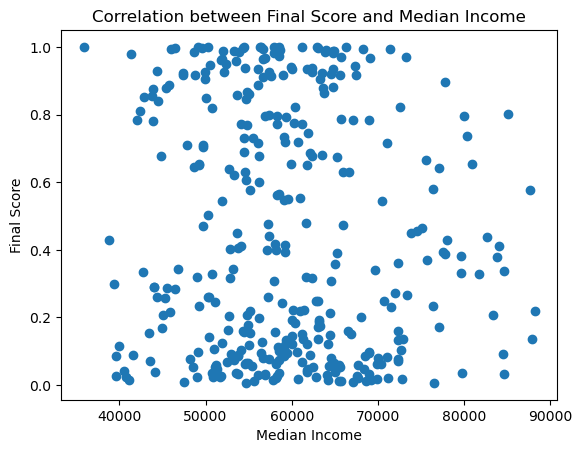

In [94]:
import pandas as pd

df_merged = pd.merge(df_merged, df_income, on='sa2_code')

# Calculate the correlation coefficient
correlation = df_merged['final_score'].corr(df_merged['median_income'])

# Output the correlation
print(f'Correlation coefficient between final score and median income: {correlation}')

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.scatter(df_merged['median_income'], df_merged['final_score'])
plt.xlabel('Median Income')
plt.ylabel('Final Score')
plt.title('Correlation between Final Score and Median Income')
plt.show()

In [95]:
conn.close()